In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
user1_heart = pd.read_csv('/content/heart_rate.csv')
user4_heart = pd.read_csv('/content/heart_rate (1).csv')
user1_eye = pd.read_csv('/content/eye_tracker (1).csv')
user4_eye = pd.read_csv('/content/eye_tracker.csv')

In [ ]:
data = [user1_heart, user4_heart, user1_eye, user4_eye]
for info in data:
  print(info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        958 non-null    float64
 1   heart_rate  958 non-null    float64
dtypes: float64(2)
memory usage: 15.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        958 non-null    float64
 1   heart_rate  958 non-null    float64
dtypes: float64(2)
memory usage: 15.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            957 non-null    float64
 1   gaze_movement   957 non-null    float64
 2   pupil_diameter  957 non-null    float64
dtypes: float64(3)
memory usage: 22.6 KB
No

# Agregasi Data

Merge User1 heart dan user1 eye, dan juga user4 heart dan user4 eye

In [ ]:
user1 = user1_heart.merge(user1_eye, on='time', how='inner')
user4 = user4_heart.merge(user4_eye, on='time', how='inner')

Buat label

In [ ]:
user1['label'] = 'amateurs'
user4['label'] = 'pros'

agregasi user1 dan user4

In [ ]:
data = pd.concat([user1, user4]).reset_index(drop=True)

In [ ]:
data

,time,heart_rate,gaze_movement,pupil_diameter,label
0,0.0,74.000000,5131.911834,5.058585,amateurs
1,1.0,73.333333,2226.583677,4.942656,amateurs
2,2.0,72.000000,1372.295497,4.990712,amateurs
3,3.0,70.933333,1170.877492,5.019090,amateurs
4,4.0,69.935484,1041.303751,4.951374,amateurs
...,...,...,...,...,...
1909,952.0,75.096774,446.233359,4.022067,pros
1910,953.0,74.451613,221.307763,4.091627,pros
1911,954.0,72.612903,89.034838,4.154748,pros
1912,955.0,71.709677,6.852606,4.226018,pros


# Cek Outlier

Menggunakan pengukuran interquartil range untuk pengecekan outlier

In [ ]:
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound)).sum()

outlier_counts = {}
for col in data.select_dtypes(include=['int64', 'float64']).columns:
    outlier_counts[col] = count_outliers_iqr(data[col])

outlier_counts_df = pd.DataFrame(list(outlier_counts.items()),
                                 columns=['Column', 'Outlier Count'])

outlier_counts_df

,Column,Outlier Count
0,time,0
1,heart_rate,35
2,gaze_movement,42
3,pupil_diameter,35


In [ ]:
print(f"presentase outlier pada heart rate {35/len(data)*100}, \npresentase outlier pada gaze movement {42/len(data)*100}, \npresentase outlier pada pupil diameter {35/len(data)*100}")

presentase outlier pada heart rate 1.8286311389759664, 
presentase outlier pada gaze movement 2.19435736677116, 
presentase outlier pada pupil diameter 1.8286311389759664


dari presentase diatas, outlier dapat dikatakan cenderung sedikit sehingga untuk mengatasi outlier akan dilakukan transformasi menggunakan robustscaler yang menggunakan median dan interquartil range agar lebih tahan outlier

menggunakan visualisasi boxplot untuk melihat outlier

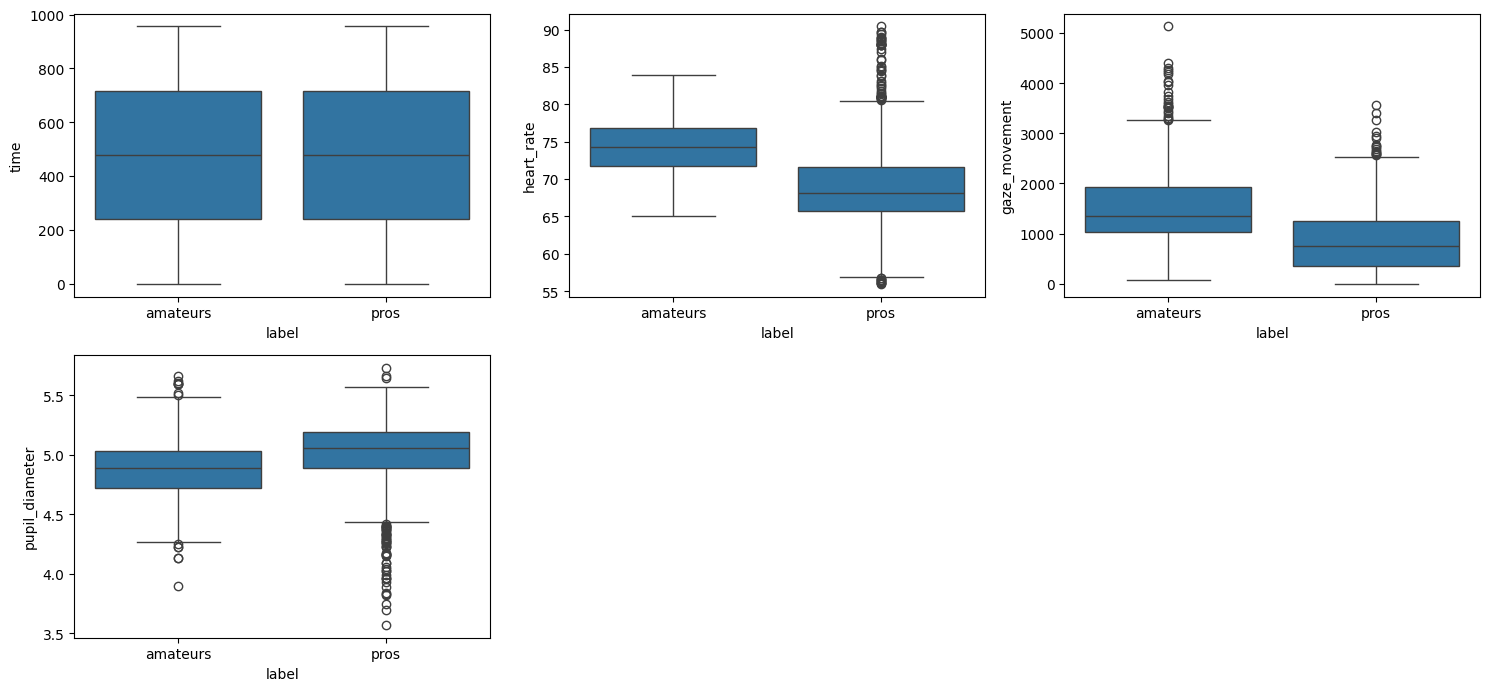

In [ ]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='label', y=column, data=data)
plt.tight_layout()
plt.show()

# Missing Value

In [ ]:
data.isna().sum()

,0
time,0
heart_rate,0
gaze_movement,0
pupil_diameter,0
label,0


dikarenakan missing value tidak ada, maka tidak akan dilakukan visualisasi dan handling missing value

# Cek Imbalance Data

<Axes: xlabel='label', ylabel='count'>

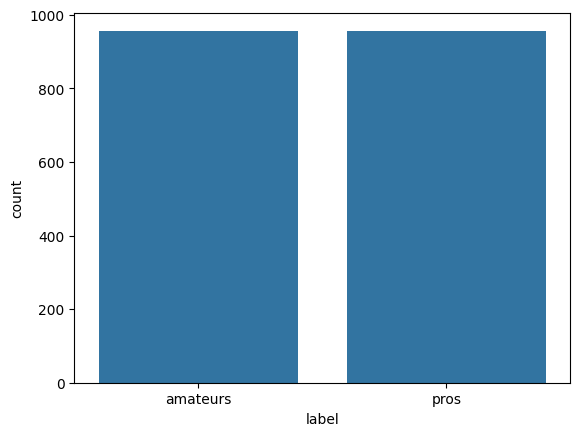

In [ ]:
sns.countplot(data=data, x='label')

proporsi antara label amateurs dan pros sudah seimbang, maka tidak perlu dilakukan treatment seperti resampling atau pembobotan pada saat pemodelan

# Korelasi antar Variable

sebelum melakukan cek korelasi, karena label masih dalam bentuk string, maka perlu dilakukan encoding, disini akan digunakan label encoder

In [ ]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

Text(0.5, 1.0, 'Korelasi Antar Variable')

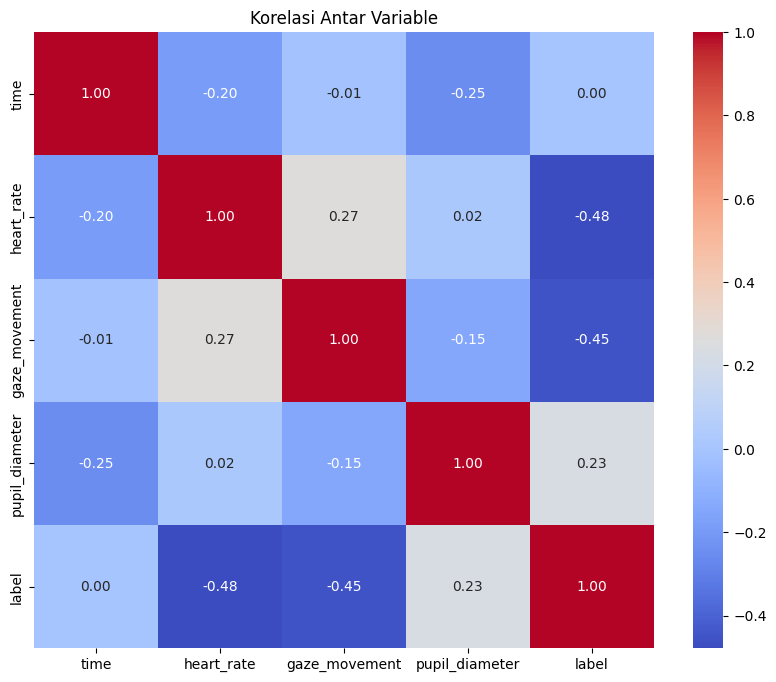

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(),fmt=".2f", annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variable')

heart rate dan gaze movement memiliki korelasi yang cukup tinggi namun memiliki arah negatif, sedangkan untuk pupil diameter memiliki korelasi 0.23 dan memiliki arah positif, selain itu time tidak memiliki korelasi sama sekali dengan label

array([[<Axes: title={'center': 'heart_rate'}>,
        <Axes: title={'center': 'gaze_movement'}>,
        <Axes: title={'center': 'pupil_diameter'}>],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

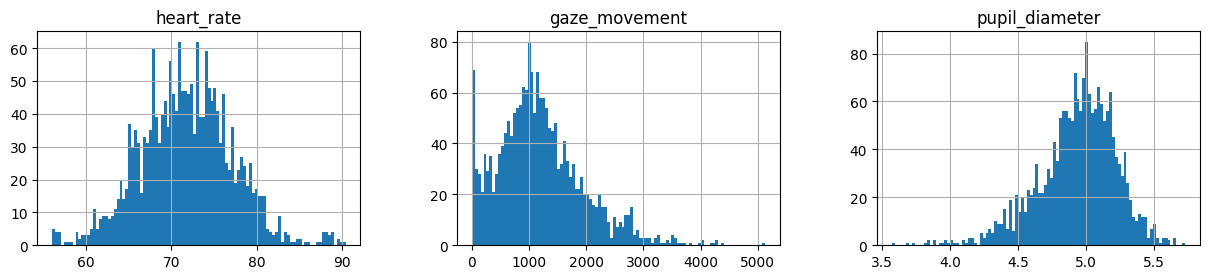

In [ ]:
data.drop(columns=['time','label']).hist(bins=100, figsize=(15, 10), layout=(3, 3))

dari visualisasi histogram diatas, heart rate memiliki distribusi cenderung normal, sedangkan gaze movement dan pupil diameter memiliki masalah pada kemencengan data sehingga menandakan terdapat anomali pada gaze movement dan pupil diameter, untuk menangani anomali tersebut bisa dilakukan normalisasi

# Robust Scaler

In [ ]:
rb = RobustScaler()
data[['heart_rate', 'gaze_movement', 'pupil_diameter']] = rb.fit_transform(data[['heart_rate', 'gaze_movement', 'pupil_diameter']])

In [ ]:
data

,time,heart_rate,gaze_movement,pupil_diameter,label
0,0.0,0.312849,4.429628,0.241247,0
1,1.0,0.220484,1.242273,-0.090398,0
2,2.0,0.035754,0.305057,0.047080,0
3,3.0,-0.112030,0.084087,0.128263,0
4,4.0,-0.250279,-0.058065,-0.065457,0
...,...,...,...,...,...
1909,952.0,0.464804,-0.710900,-2.723970,1
1910,953.0,0.375419,-0.957660,-2.524975,1
1911,954.0,0.120670,-1.102773,-2.344401,1
1912,955.0,-0.004469,-1.192932,-2.140515,1


robust scaler diatas dipakai untuk mengubah skala fitur agar lebih tahan terhadap nilai ekstrim atau outlier dan anomaly